## AF3214 Week 9 Introduction to Machine Learning in Accounting and Finance

## Portfolio Optimization using Eigen Portfolio - Unsupervised Learning

In this study, we will use dimensionality reduction techniques (e.g., Principle Component Analysis, or PCA) for portfolio management and allocation.

## <font color="red">Note: This set of scripts demonstrates a machine learning based algorithmic trading model to help you construct a near optimal portfolio and test its performance via backtesting. By applying specific trading strategy or model to historical market data, we try to assess how it would have performed in the past. You may change the size of training and testing samples to see the different results in backtesting. </font> 

## <font color="red"> You may find the scripts difficult to understand and it's okay. The purpose of this set of scripts is to let you know how machine learns from unlabled data and what factors may affect the training or testing outcome. </font>

# 1. The Problem

The goal in this study is to maximize risk-adjusted returns using dimensionality reduction-based (e.g., PCA) algorithm on 30 Dow Jones component stocks to allocate capital into different asset classes.

The dataset used for this study is Dow Jones Industrial Average (DJIA) index and its 30 component stocks from year 2000-2019. We use Alpha Vantage to download the data.

## 1.1 Getting the Data

In [40]:
from alpha_vantage.timeseries import TimeSeries
import time
import pandas as pd
import numpy as np

stock_data = {}
ts = TimeSeries(key='Your key here', output_format='pandas')

tickers = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'GS', 'NKE', 'IBM','WMT', 'DIS', 'JPM',
           'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 
           'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS'] ### 30 Dow Jones component stocks. 
'''
for ticker in tickers: 
    data, meta_data = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
    stock_data[ticker] = data
    time.sleep(10) ### Free api key only allows 5 calls per minute, so we need to set the waiting time to be long enough.
'''
## remove comments to change your dataset 

"\nfor ticker in tickers: \n    data, meta_data = ts.get_daily_adjusted(symbol=ticker, outputsize='full')\n    stock_data[ticker] = data\n    time.sleep(10) ### Free api key only allows 5 calls per minute, so we need to set the waiting time to be long enough.\n"

In [41]:
'''
stock_final_data = pd.DataFrame()
for ticker in tickers:
    stock_final_data[ticker] = stock_data[ticker].loc['2019': '2000','5. adjusted close']
stock_final_data = stock_final_data.sort_values(by='date')
stock_final_data.to_csv("Dow_Adjusted.csv")
stock_final_data.tail()
'''
## remove comments to change your dataset 

'\nstock_final_data = pd.DataFrame()\nfor ticker in tickers:\n    stock_final_data[ticker] = stock_data[ticker].loc[\'2019\': \'2000\',\'5. adjusted close\']\nstock_final_data = stock_final_data.sort_values(by=\'date\')\nstock_final_data.to_csv("Dow_Adjusted.csv")\nstock_final_data.tail()\n'

## 1.2. Loading the data and python packages

### 1.2.1. Loading Python Packages for Machine Learning

In [42]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [43]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### 1.2.2. Loading our Stock Data

In [44]:
# load dataset
dataset = read_csv('Dow_Adjusted.csv',index_col=0)

In [45]:
type(dataset)

pandas.core.frame.DataFrame

In [46]:
dataset.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,27.1839,34.0973,49.1135,0.8568,25.8976,13.5570,18.8615,39.6146,15.5528,NaN,...,4.5820,30.0735,NaN,18.8506,5.5933,20.0395,NaN,19.5976,45.0965,23.2381
2000-01-04,26.1038,32.8072,45.3601,0.7845,25.8589,13.3813,18.8615,37.3791,15.6053,NaN,...,4.3325,29.4844,NaN,18.5992,5.5215,19.3910,NaN,18.8703,43.4090,24.5991
2000-01-05,27.4345,32.6391,46.7725,0.7960,27.6696,13.8859,19.2697,37.6723,15.7767,NaN,...,4.5829,29.2319,NaN,18.7820,5.5090,20.0395,NaN,19.0418,42.3965,25.4701
2000-01-06,29.0330,32.6391,47.7011,0.7271,27.7469,14.3933,20.0162,36.6462,15.7602,NaN,...,4.5591,30.2699,NaN,18.8163,5.7109,19.9376,NaN,18.5272,42.9905,24.5991
2000-01-07,29.6091,33.0952,53.0619,0.7616,28.5524,14.8616,20.3680,38.8083,16.7970,NaN,...,4.5591,32.6825,NaN,19.5646,6.3800,19.7895,NaN,19.0007,46.2372,24.2102


## 2. Data Inspection and Analysis

### 2.1. Descriptive Statistics

In [47]:
# shape
dataset.shape

(5031, 30)

In [48]:
# types
dataset.dtypes

MMM     float64
AXP     float64
AMGN    float64
AAPL    float64
BA      float64
CAT     float64
CVX     float64
CSCO    float64
KO      float64
DOW     float64
GS      float64
HD      float64
HON     float64
IBM     float64
INTC    float64
JNJ     float64
JPM     float64
MCD     float64
MRK     float64
MSFT    float64
NKE     float64
PG      float64
CRM     float64
TRV     float64
UNH     float64
VZ      float64
V       float64
WBA     float64
WMT     float64
DIS     float64
dtype: object

In [49]:
# describe data
pd.options.display.precision = 4 # round to 4 decimal

dataset.describe()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
count,5031.0000,5031.0000,5031.0000,5031.0000,5031.0000,5031.0000,5031.0000,5031.0000,5031.0000,199.0000,...,5031.0000,5031.0000,3909.0000,5031.0000,5031.0000,5031.0000,2968.0000,5031.0000,5031.0000,5031.0000
mean,82.9086,50.7264,79.2684,13.7446,95.5525,56.0575,56.3701,21.1969,23.9959,44.7036,...,25.9538,49.3380,49.6454,55.9933,69.7301,25.4360,61.2584,38.2788,50.9559,49.6902
std,51.3350,25.3160,48.1227,15.6120,94.6691,34.9889,29.2828,10.7673,10.8208,3.6877,...,23.8836,22.0217,44.9258,35.8980,69.6564,11.9631,47.0974,17.8616,19.9282,36.3831
min,22.8970,8.3743,24.2446,0.2008,16.9701,8.6098,15.3515,6.3031,10.7132,35.9380,...,2.5290,15.1206,2.3975,12.4243,4.9554,9.9557,9.6815,15.6299,29.2920,10.8852
25%,47.4205,33.2869,44.7437,1.0517,37.0341,25.2551,28.3695,13.8743,14.3682,42.2926,...,8.0195,33.4141,11.2250,28.2294,23.3061,15.6276,19.4584,25.2638,36.4079,22.1846
50%,59.3137,41.4290,52.8200,6.1992,58.1266,51.1641,51.4469,17.4216,19.4007,44.3373,...,14.2813,44.2711,35.9100,37.9016,42.1688,19.6257,49.7758,30.4080,41.2177,29.5998
75%,122.3240,68.7116,124.9957,22.7017,115.0154,73.9313,82.1685,23.6889,33.0709,48.2943,...,44.3773,65.4678,73.7900,86.3301,92.3297,35.3259,80.5609,53.5520,63.4442,86.3626
max,229.4977,124.3932,231.5281,72.3372,430.3480,155.3298,112.8028,58.6779,52.2994,51.9604,...,100.0485,120.0191,166.9500,146.4312,288.1565,56.8732,187.4086,81.4004,117.8746,150.7338


### 2.2. Visualize the Data by Correlation Matrix using a Heatmap

Taking a first look at the correlation matrix. We will be back to this matrix after implementing the Dimensionality Reduction Models.

<Axes: title={'center': 'Correlation Matrix'}>

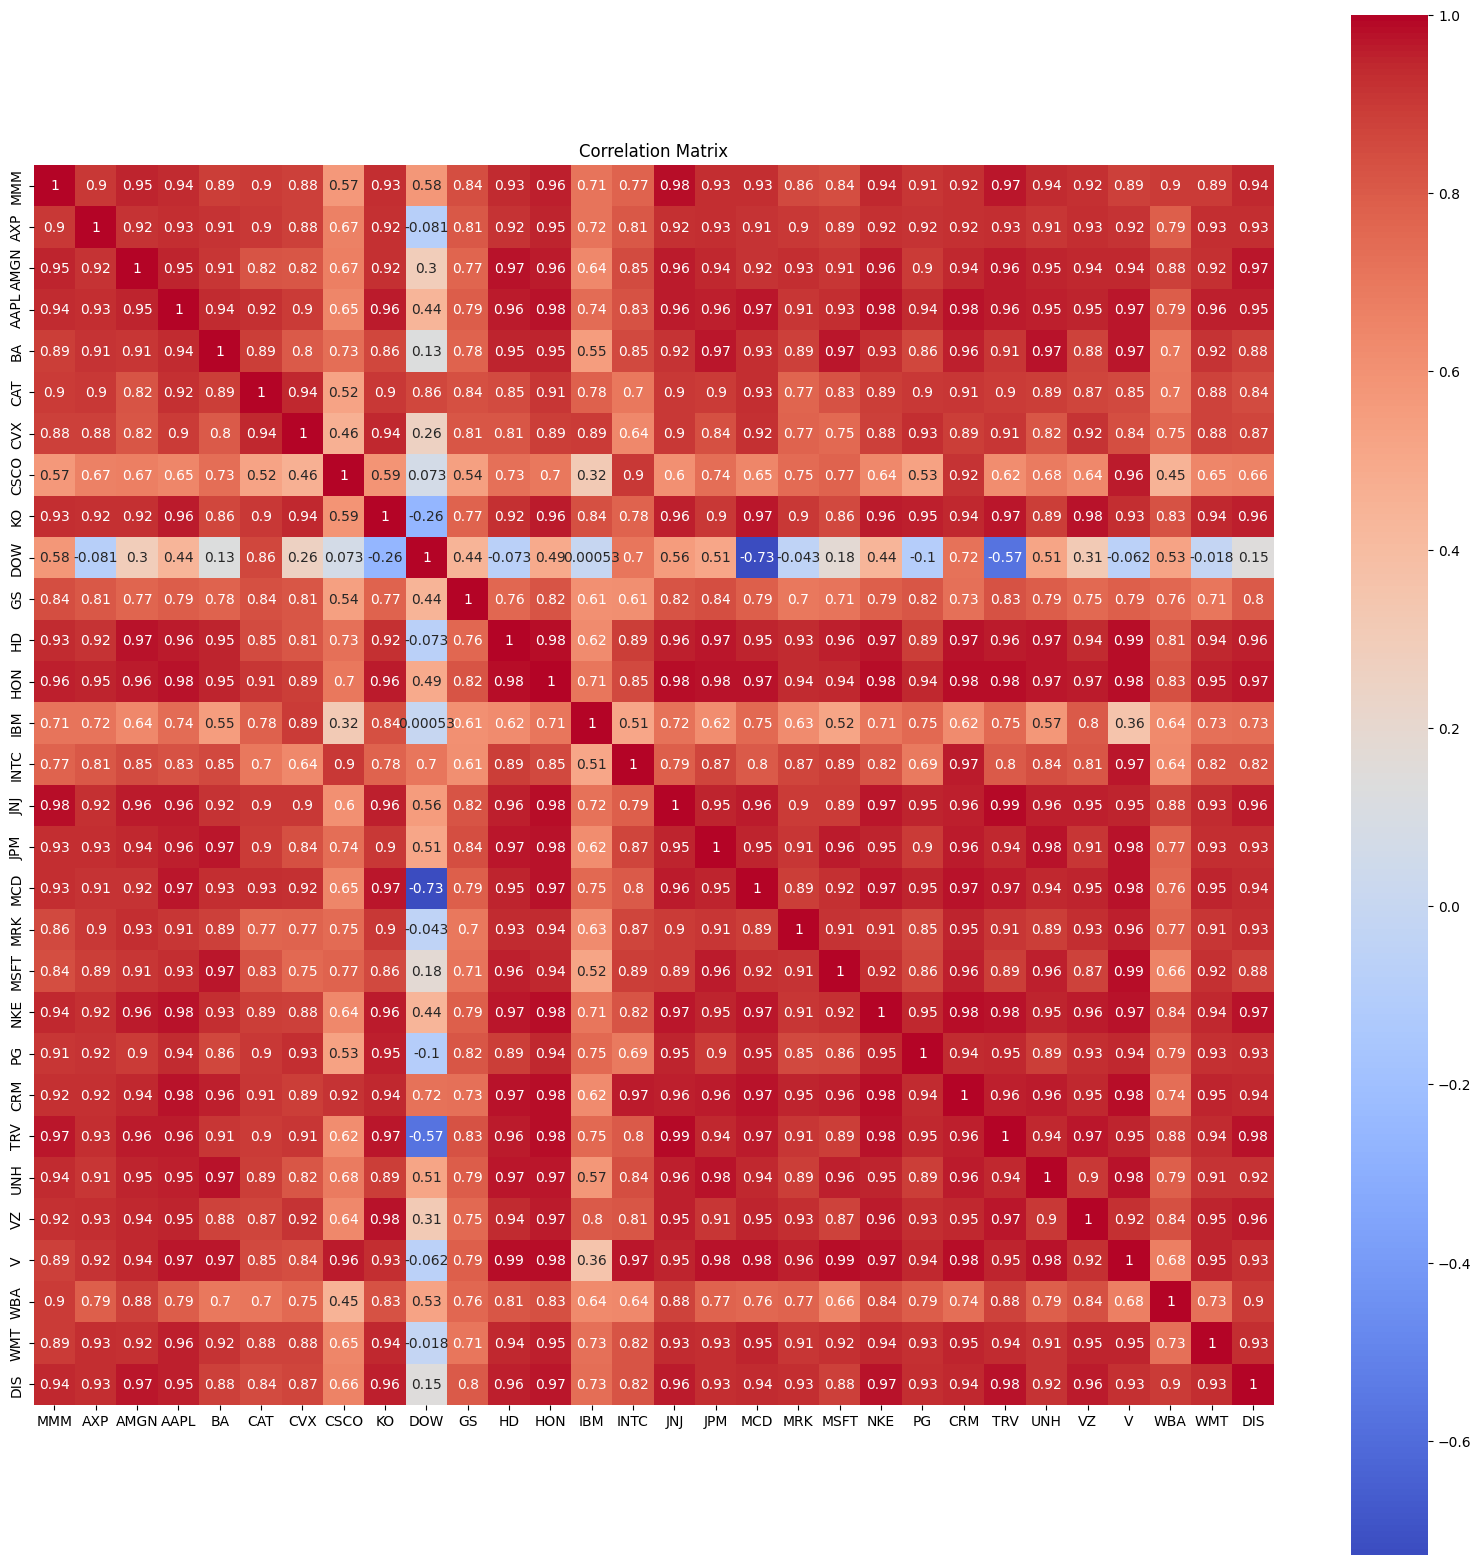

In [50]:
# correlation matrix
correlation = dataset.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='coolwarm')

### From above correlation matrix, it seems that these 30 stocks have a significant positive correlation between each other. 

## 3. Data Processing

### 3.1. Data Cleaning
Let us check for all null values in the data, we can either drop them or fill them with the mean of the column

In [51]:
# Check for any null values and remove them
print('Null Values =',dataset.isnull().values.any())
print(dataset.shape)

Null Values = True
(5031, 30)


## If a column has more than 20% missing values, we will drop this stock.

In [52]:
missing_cell = dataset.isnull().mean().sort_values(ascending=False)

print(missing_cell.head(15))

drop_list = sorted(list(missing_cell[missing_cell > 0.2].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

DOW     0.9604
V       0.4101
CRM     0.2230
AAPL    0.0000
AMGN    0.0000
MMM     0.0000
CAT     0.0000
CVX     0.0000
CSCO    0.0000
KO      0.0000
GS      0.0000
HD      0.0000
BA      0.0000
AXP     0.0000
IBM     0.0000
dtype: float64


(5031, 27)

In [53]:
dataset.head(5)

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT,DIS
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,27.1839,34.0973,49.1135,0.8568,25.8976,13.5570,18.8615,39.6146,15.5528,68.3603,...,28.8531,36.9409,4.5820,30.0735,18.8506,5.5933,20.0395,19.5976,45.0965,23.2381
2000-01-04,26.1038,32.8072,45.3601,0.7845,25.8589,13.3813,18.8615,37.3791,15.6053,64.0564,...,27.8377,35.6923,4.3325,29.4844,18.5992,5.5215,19.3910,18.8703,43.4090,24.5991
2000-01-05,27.4345,32.6391,46.7725,0.7960,27.6696,13.8859,19.2697,37.6723,15.7767,61.6876,...,29.1176,36.0694,4.5829,29.2319,18.7820,5.5090,20.0395,19.0418,42.3965,25.4701
2000-01-06,29.0330,32.6391,47.7011,0.7271,27.7469,14.3933,20.0162,36.6462,15.7602,63.6693,...,29.1731,34.8619,4.5591,30.2699,18.8163,5.7109,19.9376,18.5272,42.9905,24.5991
2000-01-07,29.6091,33.0952,53.0619,0.7616,28.5524,14.8616,20.3680,38.8083,16.7970,63.9093,...,31.9718,35.3183,4.5591,32.6825,19.5646,6.3800,19.7895,19.0007,46.2372,24.2102


In [54]:
# Drop the rows containing NA
dataset= dataset.dropna(axis=0)

dataset.head(5)

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT,DIS
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,27.1839,34.0973,49.1135,0.8568,25.8976,13.5570,18.8615,39.6146,15.5528,68.3603,...,28.8531,36.9409,4.5820,30.0735,18.8506,5.5933,20.0395,19.5976,45.0965,23.2381
2000-01-04,26.1038,32.8072,45.3601,0.7845,25.8589,13.3813,18.8615,37.3791,15.6053,64.0564,...,27.8377,35.6923,4.3325,29.4844,18.5992,5.5215,19.3910,18.8703,43.4090,24.5991
2000-01-05,27.4345,32.6391,46.7725,0.7960,27.6696,13.8859,19.2697,37.6723,15.7767,61.6876,...,29.1176,36.0694,4.5829,29.2319,18.7820,5.5090,20.0395,19.0418,42.3965,25.4701
2000-01-06,29.0330,32.6391,47.7011,0.7271,27.7469,14.3933,20.0162,36.6462,15.7602,63.6693,...,29.1731,34.8619,4.5591,30.2699,18.8163,5.7109,19.9376,18.5272,42.9905,24.5991
2000-01-07,29.6091,33.0952,53.0619,0.7616,28.5524,14.8616,20.3680,38.8083,16.7970,63.9093,...,31.9718,35.3183,4.5591,32.6825,19.5646,6.3800,19.7895,19.0007,46.2372,24.2102


Computing Daily Return

In [55]:
# Log Returns (in %)
#data_returns = np.log(dataset / dataset.shift(1)) 

# Simple Daily Returns (in %)
data_returns = dataset.pct_change(1)

# Let's remove "outliers" that beyong 3 standard deviation
# If you remember in Week 8, when we discuss standard deviation
# 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean
# for those beyond 3 standard deviation, we consider them as "outliers".
data_returns= data_returns[data_returns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]
data_returns

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT,DIS
date,,,,,,,,,,,,,,,,,,,,,
2000-01-20,-0.0372,0.0168,-0.0026,0.0651,-0.0237,-0.0442,-5.0034e-03,0.0009,0.0097,-0.0171,...,0.0201,-0.0093,-0.0237,-0.0243,-0.0055,0.0252,0.0031,0.0000,-1.0615e-02,-0.0322
2000-02-02,-0.0173,-0.0284,-0.0239,-0.0144,0.0201,0.0058,-6.7316e-03,-0.0331,-0.0301,-0.0013,...,0.0009,-0.0207,0.0161,-0.0087,-0.0488,0.0265,-0.0042,0.0045,-5.2820e-03,0.0347
2000-02-03,-0.0088,-0.0079,0.0039,0.0455,-0.0267,-0.0260,-1.4402e-02,0.0342,-0.0200,-0.0631,...,-0.0082,0.0279,0.0093,-0.0083,-0.0448,-0.0089,-0.0147,-0.0021,0.0000e+00,0.0169
2000-02-04,-0.0287,-0.0092,0.0098,0.0454,0.0129,0.0000,-3.5363e-02,0.0280,0.0181,-0.0081,...,-0.0156,0.0284,-0.0249,-0.0313,0.0045,0.0247,0.0021,0.0107,-3.5457e-02,0.0066
2000-03-02,-0.0008,-0.0140,0.0038,-0.0638,-0.0102,-0.0126,5.8472e-03,0.0084,-0.0269,0.0158,...,-0.0125,0.0282,0.0466,-0.0107,0.0031,-0.0388,0.0056,-0.0367,3.1837e-02,-0.0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.0100,0.0020,-0.0029,0.0010,-0.0135,-0.0069,8.3105e-05,-0.0067,-0.0036,0.0036,...,-0.0033,-0.0002,0.0010,0.0026,-0.0029,-0.0019,-0.0020,-0.0038,4.0326e-03,0.0042
2019-12-26,-0.0005,0.0054,-0.0018,0.0198,-0.0092,0.0050,2.1605e-03,0.0015,0.0057,0.0057,...,-0.0011,0.0082,0.0057,0.0000,0.0034,0.0038,0.0002,0.0094,8.3675e-05,0.0028
2019-12-27,0.0038,-0.0018,-0.0015,-0.0004,0.0007,0.0004,-2.4876e-03,-0.0017,0.0060,-0.0024,...,0.0018,0.0018,0.0085,0.0069,0.0037,0.0011,0.0039,0.0020,5.8568e-04,0.0003


### 3.2. Data Transformation

Standardization in statistics is a useful technique to transform attributes to a standard Normal distribution with a mean of 0 and a standard deviation of 1.

In this study, we need to keep all variables in the same scale before applying PCA. If not, a feature with large values will dominate the result. 

We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and standard deviation = 1).

In [56]:
%pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data_returns)
standardzied_Dataset = pd.DataFrame(scaler.fit_transform(data_returns),columns = data_returns.columns, index = data_returns.index)

# Let's take a look at the standardized data
data_returns.dropna(how='any', inplace=True)
standardzied_Dataset.dropna(how='any', inplace=True)
standardzied_Dataset.head(5)

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT,DIS
date,,,,,,,,,,,,,,,,,,,,,
2000-01-20,-3.5062,1.0959,-0.2078,3.3667,-1.6600,-2.8405,-0.4501,0.0171,0.9815,-1.0838,...,1.6149,-0.7510,-1.8320,-2.7403,-0.4887,1.6618,0.2406,-0.0357,-1.0131,-2.4431
2000-02-02,-1.6592,-1.9520,-1.6746,-0.8270,1.2910,0.3140,-0.5868,-2.0498,-3.2676,-0.1044,...,0.0262,-1.6019,1.1416,-1.0229,-4.0156,1.7469,-0.4028,0.3028,-0.5168,2.5596
2000-02-03,-0.8657,-0.5704,0.2452,2.3334,-1.8578,-1.6924,-1.1932,2.0446,-2.1923,-3.9301,...,-0.7261,2.0403,0.6335,-0.9753,-3.6936,-0.6817,-1.3230,-0.1912,-0.0253,1.2289
2000-02-04,-2.7128,-0.6575,0.6540,2.3258,0.8048,-0.0512,-2.8505,1.6660,1.8840,-0.5234,...,-1.3385,2.0777,-1.9207,-3.5174,0.3252,1.6294,0.1466,0.7696,-3.3249,0.4583
2000-03-02,-0.1294,-0.9822,0.2397,-3.4335,-0.7489,-0.8470,0.4078,0.4707,-2.9211,0.9574,...,-1.0818,2.0641,3.4246,-1.2340,0.2109,-2.7308,0.4620,-2.7870,2.9374,-0.4441


In [58]:
standardzied_Dataset.describe()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT,DIS
count,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,...,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03,4.0710e+03
mean,1.8326e-17,7.8542e-18,-6.9815e-18,-6.8070e-17,1.0472e-17,-6.1961e-17,7.1560e-17,6.1088e-18,4.5380e-17,3.7962e-17,...,1.0472e-16,-5.4107e-17,-1.3439e-16,1.0156e-16,3.4908e-18,-1.6581e-16,-4.0144e-17,-5.4107e-17,2.7926e-17,5.2361e-18
std,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,...,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00,1.0001e+00
min,-3.9100e+00,-4.4434e+00,-4.0056e+00,-3.8069e+00,-3.6524e+00,-3.6976e+00,-3.7402e+00,-4.4232e+00,-4.0583e+00,-4.1726e+00,...,-4.0242e+00,-4.1703e+00,-3.9705e+00,-4.3435e+00,-4.2880e+00,-3.9699e+00,-4.0342e+00,-3.8024e+00,-4.0890e+00,-4.1018e+00
25%,-5.4541e-01,-4.9203e-01,-5.7435e-01,-5.3082e-01,-6.1017e-01,-5.6842e-01,-5.9578e-01,-5.0455e-01,-5.6417e-01,-5.6623e-01,...,-5.7996e-01,-5.6057e-01,-5.7056e-01,-5.5351e-01,-5.4888e-01,-5.6394e-01,-5.8854e-01,-6.0023e-01,-5.6014e-01,-5.4597e-01
50%,-1.8649e-03,-5.1296e-03,-2.1100e-02,-2.2063e-02,-1.0500e-02,-1.4733e-02,1.3732e-02,2.5699e-03,-3.1317e-04,6.7419e-03,...,-8.2560e-03,-2.5900e-02,-6.1726e-03,-1.4468e-02,4.2374e-03,-1.3468e-02,1.4864e-02,-1.8240e-02,9.9812e-03,7.8899e-03
75%,5.7714e-01,5.3338e-01,5.8458e-01,5.4479e-01,6.0454e-01,5.8140e-01,6.0233e-01,5.3945e-01,5.5380e-01,5.8398e-01,...,5.7859e-01,5.6075e-01,5.6112e-01,5.5115e-01,5.5329e-01,5.6102e-01,5.7985e-01,5.8853e-01,5.6494e-01,5.6201e-01
max,4.0153e+00,4.4049e+00,4.0816e+00,3.9992e+00,3.6863e+00,3.7410e+00,3.7205e+00,4.3726e+00,4.0745e+00,4.2625e+00,...,4.1181e+00,4.1904e+00,4.0789e+00,4.1519e+00,4.2639e+00,4.0166e+00,3.8292e+00,3.8204e+00,4.1348e+00,4.0941e+00


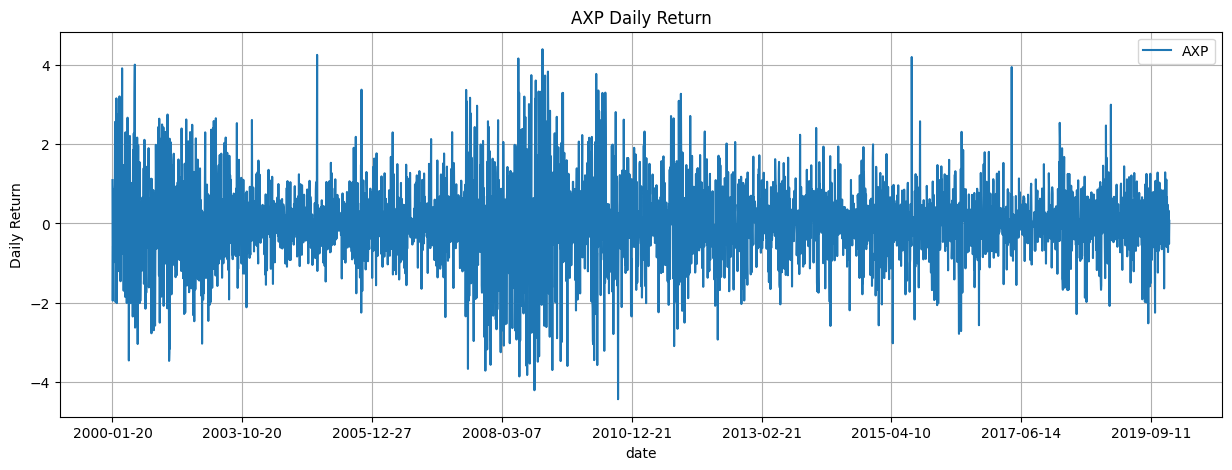

In [59]:
# Let's take a look at the Returns for American Express
plt.figure(figsize=(15, 5))
plt.title("AXP Daily Return")
plt.ylabel("Daily Return")
standardzied_Dataset.AXP.plot()
plt.grid(True);
plt.legend()
plt.show()

# 4. Algorithms and Models Evaluation

### 4.1. Train Test Split

Now we need to divide the portfolio into training sample and testing sample (e.g., train test split) to perform the analysis regarding the best porfolio and backtesting shown later. 

In [60]:
# the length of our cleaned dataset
len(standardzied_Dataset)

4071

In [61]:
# the % allocate to training sample
t = 0.8
percentage = int(len(standardzied_Dataset) * t)
percentage

3256

In [62]:
# Dividing the dataset into training and testing samples

percentage = int(len(standardzied_Dataset) * t)
X_training = standardzied_Dataset[:percentage]
X_testing = standardzied_Dataset[percentage:]
print("Training sample: ",len(X_training))
print("Testing sample: ",len(X_testing))

X_train_raw = data_returns[:percentage]
X_test_raw = data_returns[percentage:]
print("Raw Data Training sample: ", len(X_train_raw))
print("Raw Data Testing sample: ", len(X_test_raw))

stock_tickers = standardzied_Dataset.columns.values
n_tickers = len(stock_tickers)
print("Number of tickers after data cleaning", n_tickers)

Training sample:  3256
Testing sample:  815
Raw Data Training sample:  3256
Raw Data Testing sample:  815
Number of tickers after data cleaning 27


### 4.2. Model Evaluation by Applying Principle Component Analysis (PCA)

Below we create a function to compute PCA from sklearn library using the training sample. This function will compute an inversed elbow chart that shows the amount of principle components and how many of them explain the variance threshold.

In [63]:
pca = PCA()
Principal_Component=pca.fit(X_training)

### First Principal Component / Eigenvector

In [64]:
print(pca.components_[0])
print(len(pca.components_[0]))

[0.22527844 0.23148387 0.16932139 0.15712119 0.19157568 0.20525556
 0.17997341 0.20040529 0.17093388 0.21374475 0.2087245  0.23550339
 0.20438752 0.19918021 0.17139448 0.23519283 0.15771199 0.17288519
 0.20033565 0.17798975 0.17036088 0.20201904 0.14341466 0.17181737
 0.16785209 0.17413498 0.21413697]
27


### 4.2.1. Explained Variance using PCA

,Explained Variance
0,37.41%
1,42.86%
2,47.18%
3,50.88%
4,54.23%
5,57.49%
6,60.37%
7,63.15%
8,65.80%
9,68.26%


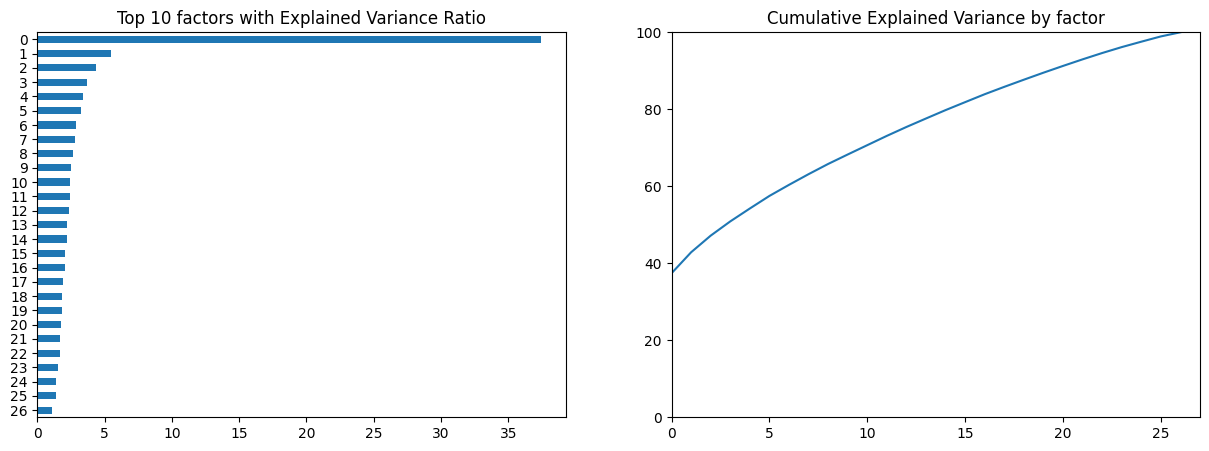

In [76]:
Num_Eigenvalues=100
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

Series1 = pd.Series(pca.explained_variance_ratio_[:Num_Eigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:Num_Eigenvalues]).cumsum()*100

Series1.plot.barh(ylim=(0,27), label="woohoo",title='Top 10 factors with Explained Variance Ratio',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,27),ax=axes[1], title='Cumulative Explained Variance by factor');

# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(Num_Eigenvalues).style.format('{:,.2%}'.format)

We can see from above two plots that factor 0 explains around 39%-40% of the daily return variation. We call such factor as the dominant factor, which is usually interpreted as ‘The Market’, depending on the results of closer inspection.

The plot on the right hand side shows the cumulative explained variance in a curve and indicates that 10 factors explain around 68% of the returns of our cross-section of stocks.  

### 4.2.2. Portfolio Weights

Now we will compute and determine the weights of each principle component, and then we can visualize a scatterplot such that we can see an organized descending plot with the respective weight of every stock at the current chosen principle component.

In [66]:
def PCWeights():

    # 27 weights for each Principal Component
    weights = pd.DataFrame()

    for i in range(len(pca.components_)): 
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
        #print(weights)

    weights = weights.values.T
    return weights

weights=PCWeights()
print(weights, '\n\n', len(weights))

[[ 4.37252600e-02  4.49296987e-02  3.28643154e-02  3.04963275e-02
   3.71837470e-02  3.98389333e-02  3.49318114e-02  3.88975230e-02
   3.31772911e-02  4.14866364e-02  4.05122346e-02  4.57098649e-02
   3.96704514e-02  3.86597416e-02  3.32666909e-02  4.56495857e-02
   3.06109971e-02  3.35560296e-02  3.88840060e-02  3.45467946e-02
   3.30660745e-02  3.92107425e-02  2.78359681e-02  3.33487707e-02
   3.25791337e-02  3.37986065e-02  4.15627637e-02]
 [ 7.37404850e-02 -2.25718542e-01  1.95092687e-01 -1.01651553e+00
  -1.16802566e-02 -3.52649753e-01  1.57861167e-01 -1.03672525e+00
   8.90246599e-01 -5.21163241e-01  1.68967195e-01 -1.96919335e-01
  -4.70362622e-01 -9.68566941e-01  1.00803363e+00 -3.90317766e-01
   5.04354724e-01  8.73423251e-01 -5.84724102e-01  8.42458299e-02
   9.91220024e-01  2.41383125e-01  4.95712902e-01  3.85676880e-01
   4.52697791e-01  4.69264155e-01 -2.16577103e-01]
 [-2.66393506e-01 -7.29287495e-01  7.77515578e-01  7.39360827e-01
  -5.55629778e-01 -6.53742855e-01 -4.782

In [67]:
weights[0]

array([0.04372526, 0.0449297 , 0.03286432, 0.03049633, 0.03718375,
       0.03983893, 0.03493181, 0.03889752, 0.03317729, 0.04148664,
       0.04051223, 0.04570986, 0.03967045, 0.03865974, 0.03326669,
       0.04564959, 0.030611  , 0.03355603, 0.03888401, 0.03454679,
       0.03306607, 0.03921074, 0.02783597, 0.03334877, 0.03257913,
       0.03379861, 0.04156276])

In [68]:
print(pca.components_[0])# component loadings (which represent the contribution of each original stock to that component)
print(sum(pca.components_[0])) #This makes the normalized loadings for a single component add up to 1.
print(pca.components_[0]/sum(pca.components_[0])) #weights

[0.22527844 0.23148387 0.16932139 0.15712119 0.19157568 0.20525556
 0.17997341 0.20040529 0.17093388 0.21374475 0.2087245  0.23550339
 0.20438752 0.19918021 0.17139448 0.23519283 0.15771199 0.17288519
 0.20033565 0.17798975 0.17036088 0.20201904 0.14341466 0.17181737
 0.16785209 0.17413498 0.21413697]
5.152134928134312
[0.04372526 0.0449297  0.03286432 0.03049633 0.03718375 0.03983893
 0.03493181 0.03889752 0.03317729 0.04148664 0.04051223 0.04570986
 0.03967045 0.03865974 0.03326669 0.04564959 0.030611   0.03355603
 0.03888401 0.03454679 0.03306607 0.03921074 0.02783597 0.03334877
 0.03257913 0.03379861 0.04156276]


array([[<Axes: title={'center': 'Portfolio 0'}>],
       [<Axes: title={'center': 'Portfolio 1'}>],
       [<Axes: title={'center': 'Portfolio 2'}>],
       [<Axes: title={'center': 'Portfolio 3'}>],
       [<Axes: title={'center': 'Portfolio 4'}>],
       [<Axes: title={'center': 'Portfolio 5'}>],
       [<Axes: title={'center': 'Portfolio 6'}>],
       [<Axes: title={'center': 'Portfolio 7'}>],
       [<Axes: title={'center': 'Portfolio 8'}>],
       [<Axes: title={'center': 'Portfolio 9'}>]], dtype=object)

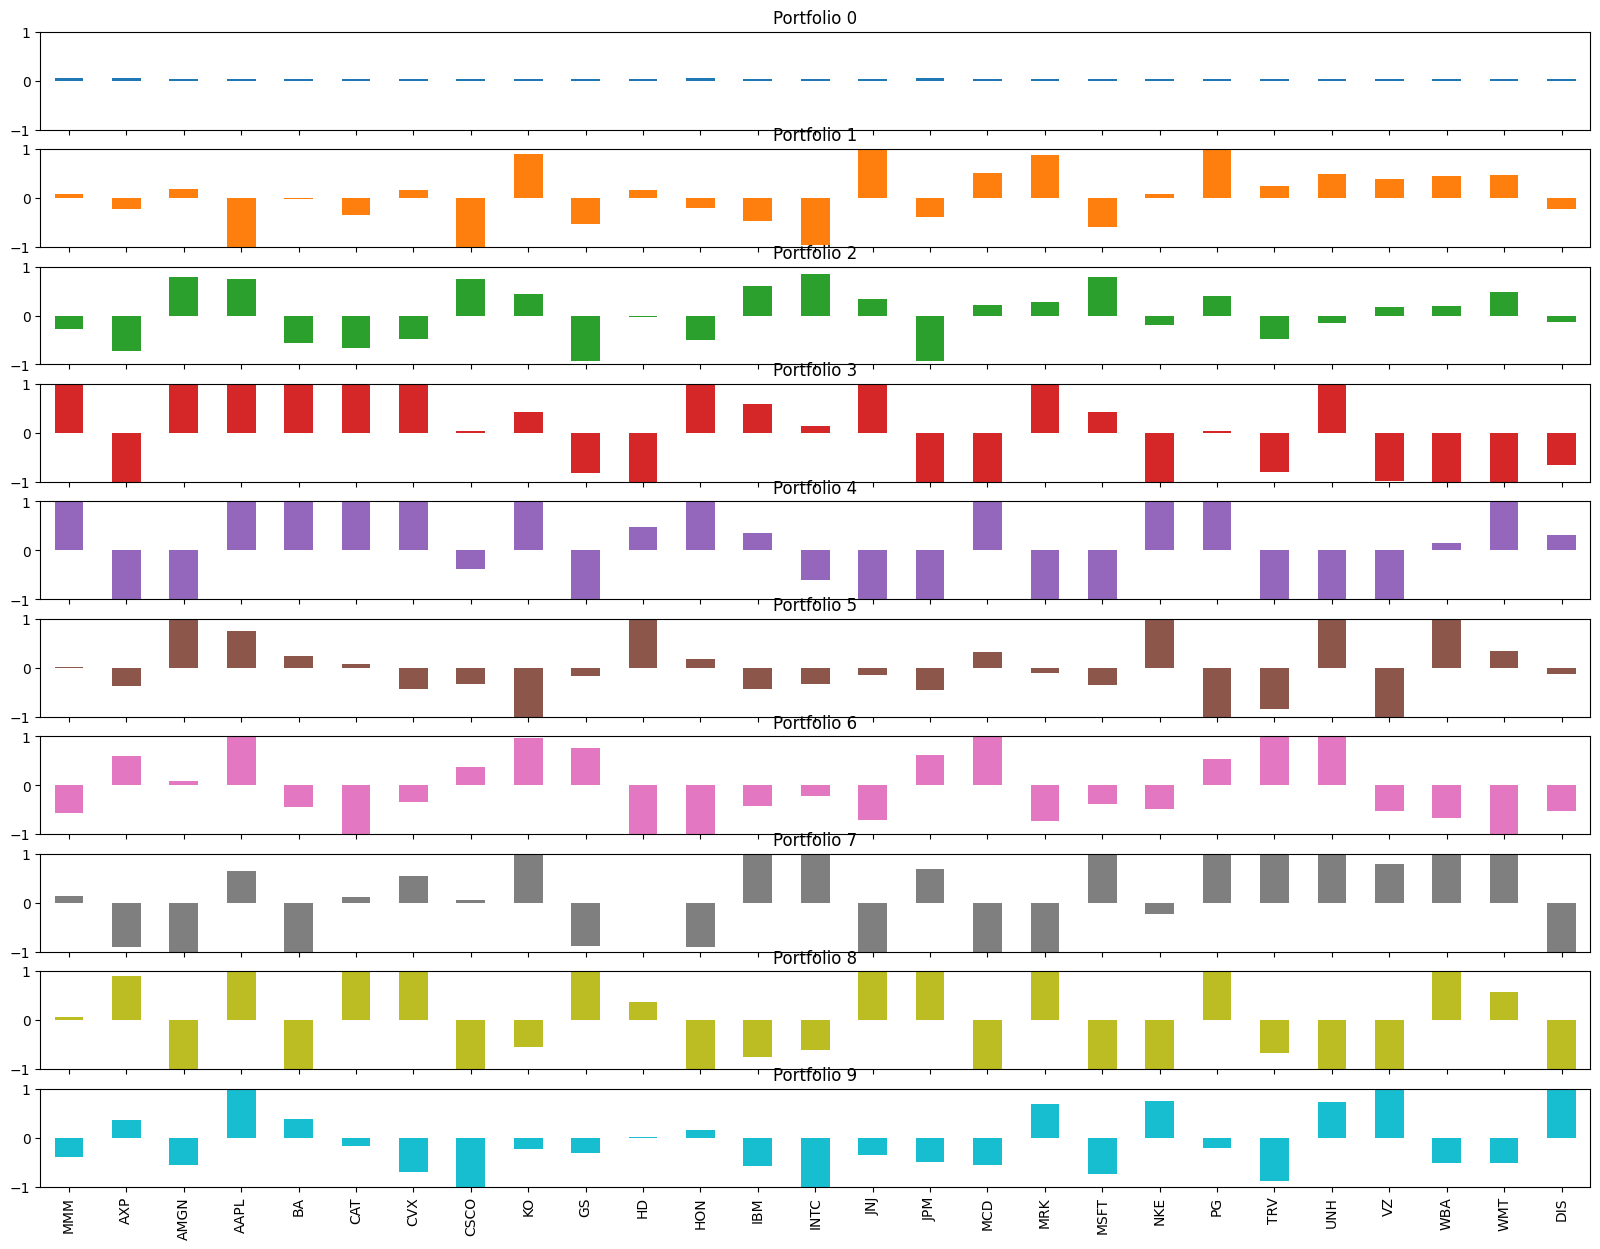

In [69]:
Num_Components = 10 # num of top portfolio
        
top_Portfolios = pd.DataFrame(pca.components_[:Num_Components], columns=dataset.columns)
eigen_portfolios = top_Portfolios.div(top_Portfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(Num_Components)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(Num_Components),1), figsize=(20,15), legend=False, sharey=True, ylim= (-1,1))

<Axes: >

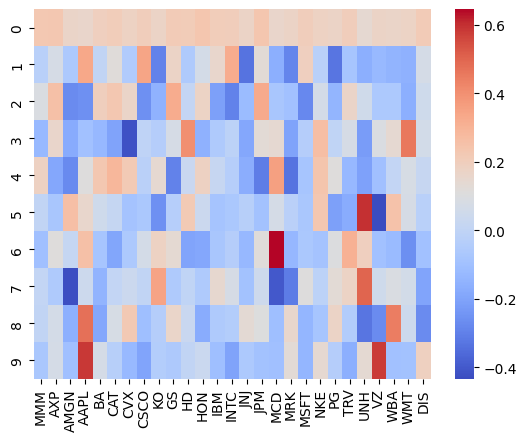

In [70]:
# plotting heatmap 
sns.heatmap(top_Portfolios, cmap='coolwarm') 

The plots and the heatmap above shown the contributions of different stocks in each eigenvector.

### 4.2.3. Finding the Best Eigen Portfolio

In order to find the best eigen portfolios and perform backtesting in the next step, we use the sharpe ratio. A higher sharpe ratio explains higher returns and lower risk for one particular portfolio. 

The annualized sharpe ratio is computed by dividing the annualized log returns against the annualized risk. 
For annualized log return we apply the geometric average of all the returns in respect to the number of trading days per year. Annualized risk is computed by taking the standard deviation of the returns and multiplying it by the square root of the number of trading days per year.

In [71]:
# Sharpe Ratio

def sharpe_ratio(daily_returns, trading_days=252):
    
    # Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    # It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    # daily_returns is returns of a signle eigen portfolio.

    n_years = daily_returns.shape[0] / trading_days
    annualized_return = np.power(np.prod(1 + daily_returns), (1/n_years)) - 1     
    annualized_vol = daily_returns.std() * np.sqrt(trading_days)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

We construct a loop to compute the principle component’s weights for each eigen
portfolio, which then uses the sharpe ratio function to look for the portfolio with the
highest sharpe ratio. Once we know which portfolio has the highest sharpe ratio, we
can visualize its performance against the DJIA Index for comparison.

Eigen portfolio #0 with the highest Sharpe. Return 12.09%, vol = 13.50%, Sharpe = 0.89
    Return      Vol  Sharpe
0   0.1209   0.1350  0.8950
6   0.2274   0.9687  0.2347
13  0.0296   1.2507  0.0237
23 -1.0000  15.1406 -0.0660
21 -1.0000   9.1370 -0.1094
2  -0.0569   0.4554 -0.1249
17 -1.0000   6.2795 -0.1592
9  -0.2404   0.9645 -0.2493
4  -0.9992   3.1187 -0.3204
19 -0.9936   2.9956 -0.3317
12 -0.8865   2.5870 -0.3427
11 -0.9949   2.8924 -0.3440
7  -0.9715   2.6129 -0.3718
10 -0.7664   1.9902 -0.3851
8  -0.9889   2.5432 -0.3888
22 -0.7920   2.0083 -0.3944
15 -0.9637   2.4185 -0.3985
25 -0.9580   2.3568 -0.4065
5  -0.3664   0.8880 -0.4126
1  -0.2603   0.6021 -0.4324
3  -0.8614   1.9277 -0.4469
20 -0.9631   2.1198 -0.4544
24 -0.7896   1.6685 -0.4732
18 -0.8056   1.6741 -0.4812


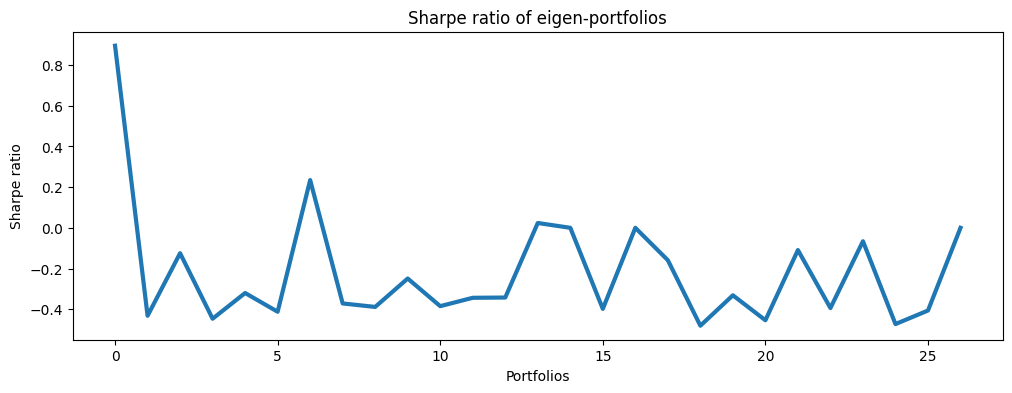

In [72]:
def optimized_Portfolio():
    n_portfolios = len(pca.components_)
    #print(n_portfolios)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = standardzied_Dataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        #print(er)
        #print(vol)
        #print(sharpe)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric.astype(float))
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(25))

    plt.show()

optimized_Portfolio()

Sum of Portfolio Weights is:  weights    100.0
dtype: float64


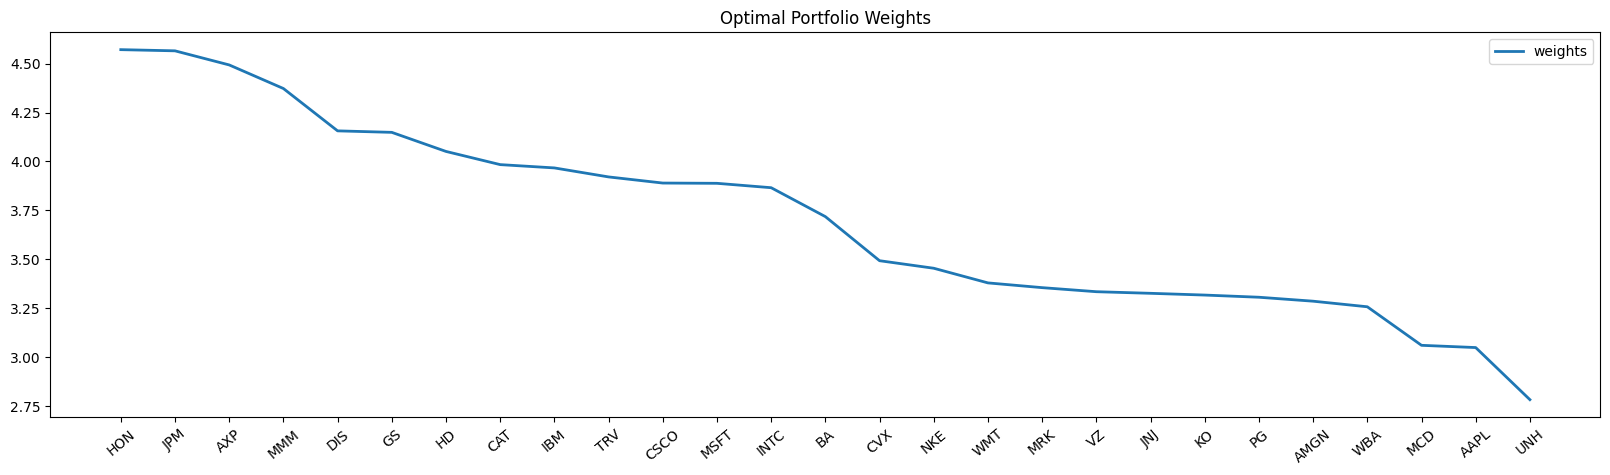

,weights
HON,4.5710
JPM,4.5650
AXP,4.4930
MMM,4.3725
DIS,4.1563
GS,4.1487
HD,4.0512
CAT,3.9839
IBM,3.9670
TRV,3.9211


In [73]:
weights = PCWeights()
portfolio = pd.DataFrame()

def optimal_port(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of Portfolio Weights is: ', np.sum(portfolio))
        portfolio.plot(title='Optimal Portfolio Weights', figsize=(20,5), xticks=range(0, len(stock_tickers), 1), rot=40, 
            linewidth=2
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
optimal_port(weights=weights[0], plot=True)

The chart shows the allocation of the best portfolio. The weights in the chart are in
percentages. 

### 4.2.4. Backtesting Eigenportfolio

We will now try to backtest our model on the test set, by looking at few top and bottom portfolios.

Eigen-Portfolio 0
Return = 28.46%
Volatility = 10.65%
Sharpe = 2.67


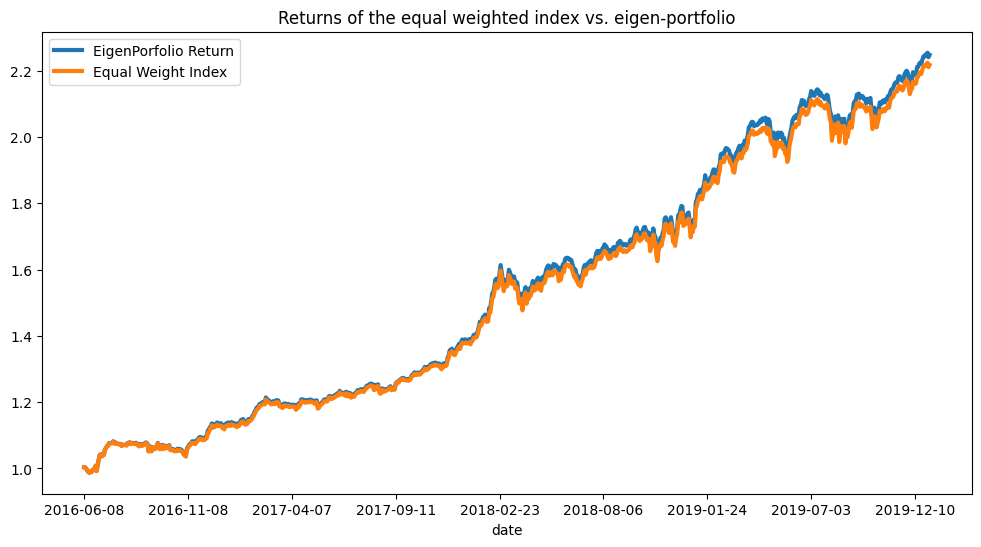

Eigen-Portfolio 1
Return = 12.89%
Volatility = 44.72%
Sharpe = 0.29


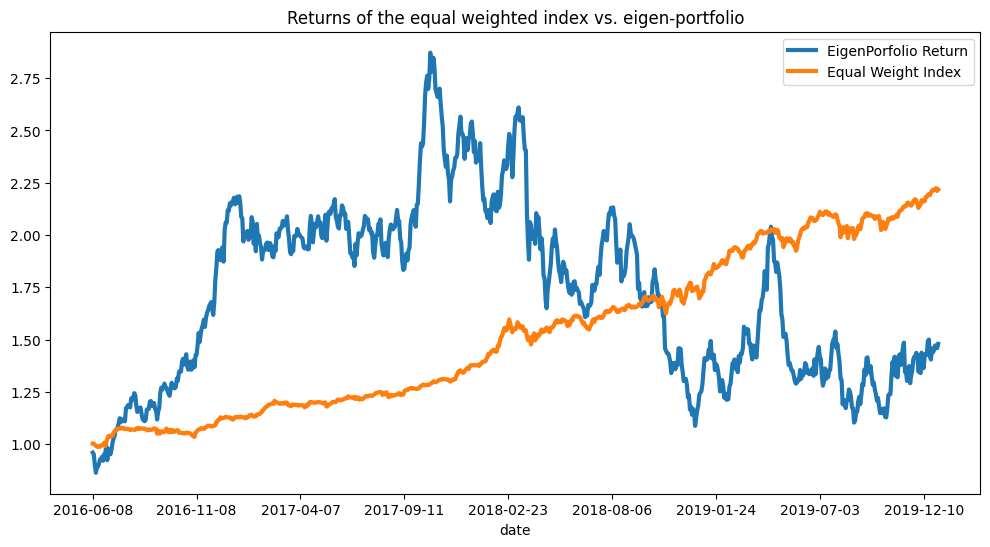

Eigen-Portfolio 2
Return = -10.12%
Volatility = 38.51%
Sharpe = -0.26


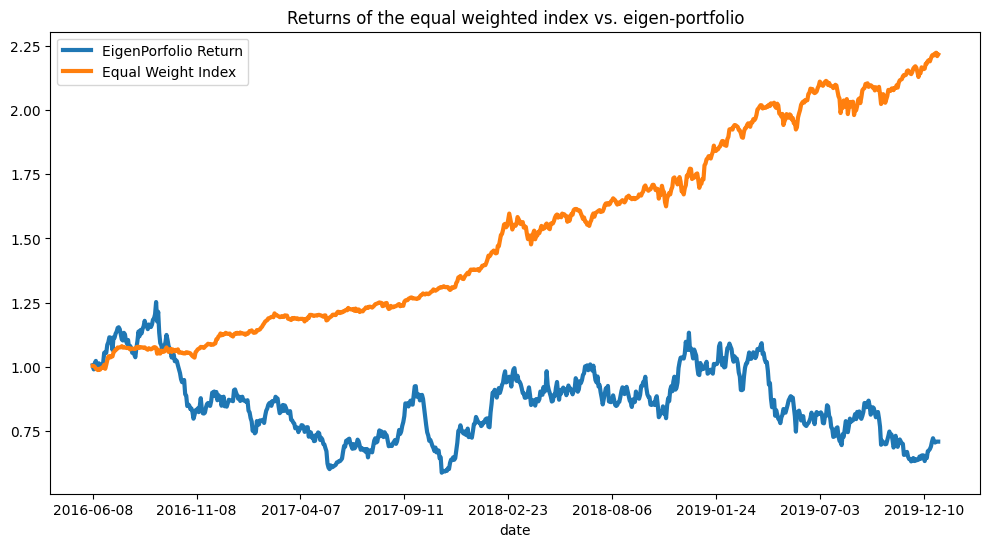

Eigen-Portfolio 3
Return = 37.84%
Volatility = 157.93%
Sharpe = 0.24


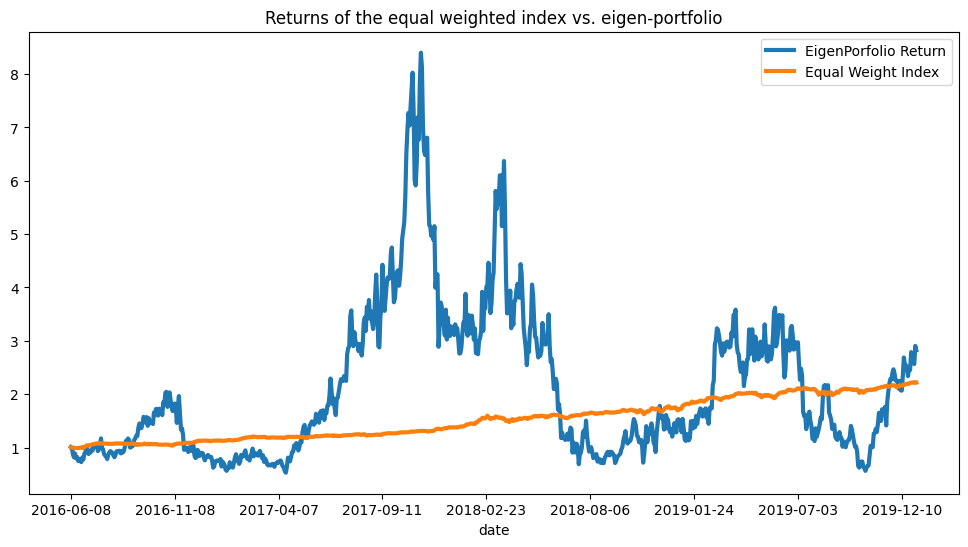

Eigen-Portfolio 4
Return = -99.89%
Volatility = 275.37%
Sharpe = -0.36


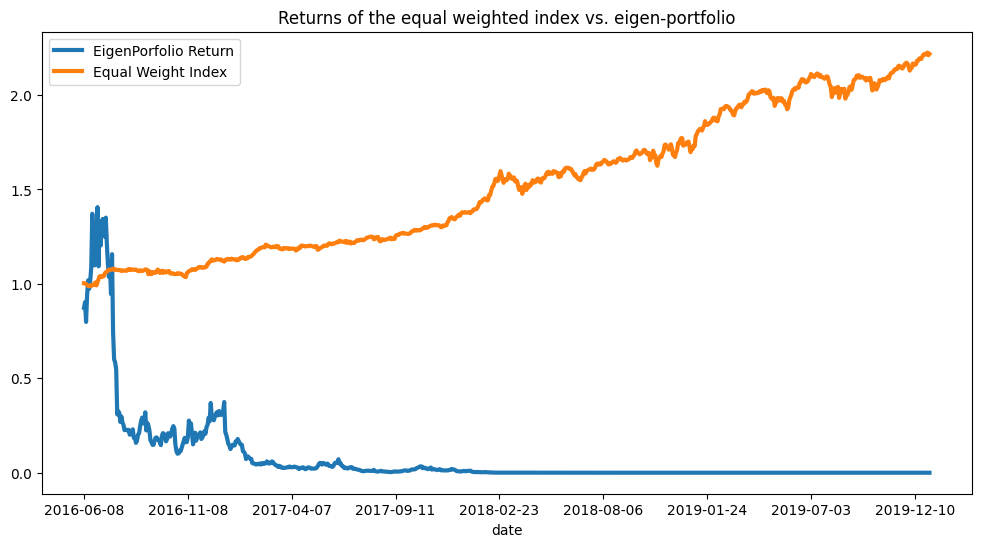

Eigen-Portfolio 5
Return = 1.16%
Volatility = 64.14%
Sharpe = 0.02


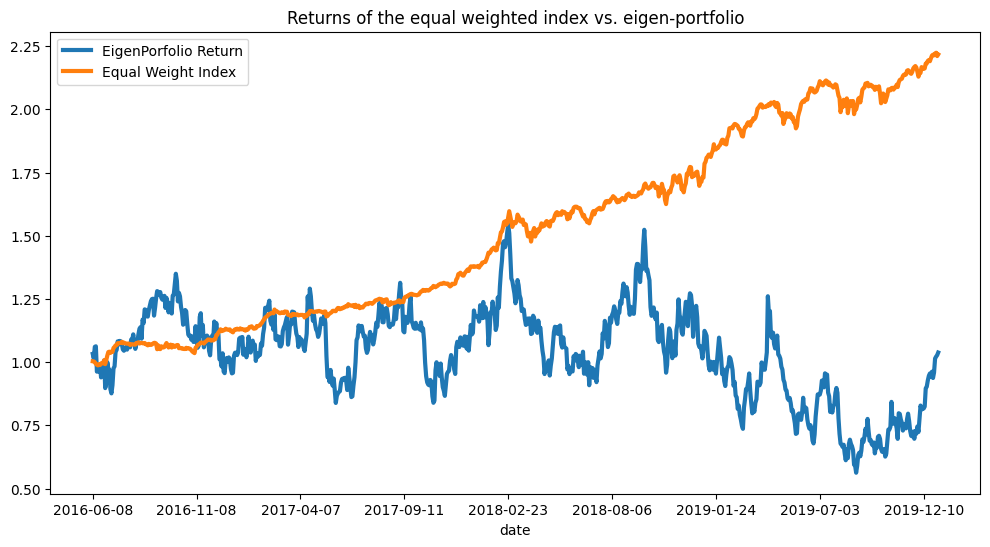

Eigen-Portfolio 6
Return = 55.94%
Volatility = 83.31%
Sharpe = 0.67


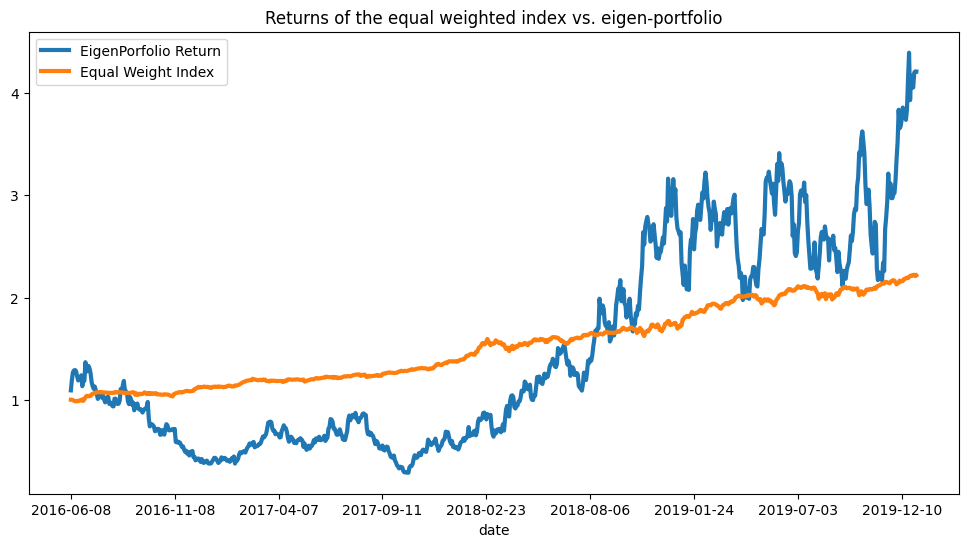

Eigen-Portfolio 7
Return = -90.08%
Volatility = 237.98%
Sharpe = -0.38


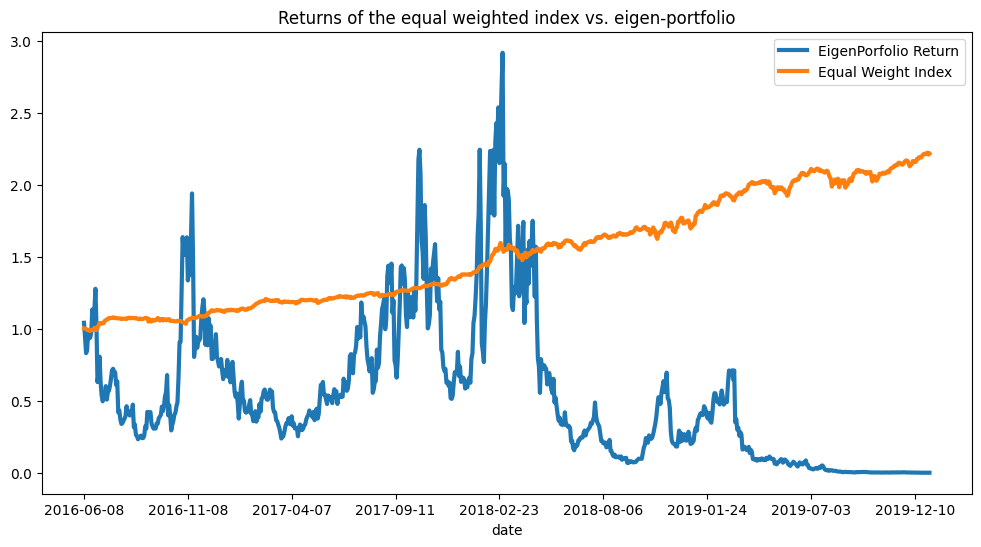

Eigen-Portfolio 8
Return = -98.98%
Volatility = 240.56%
Sharpe = -0.41


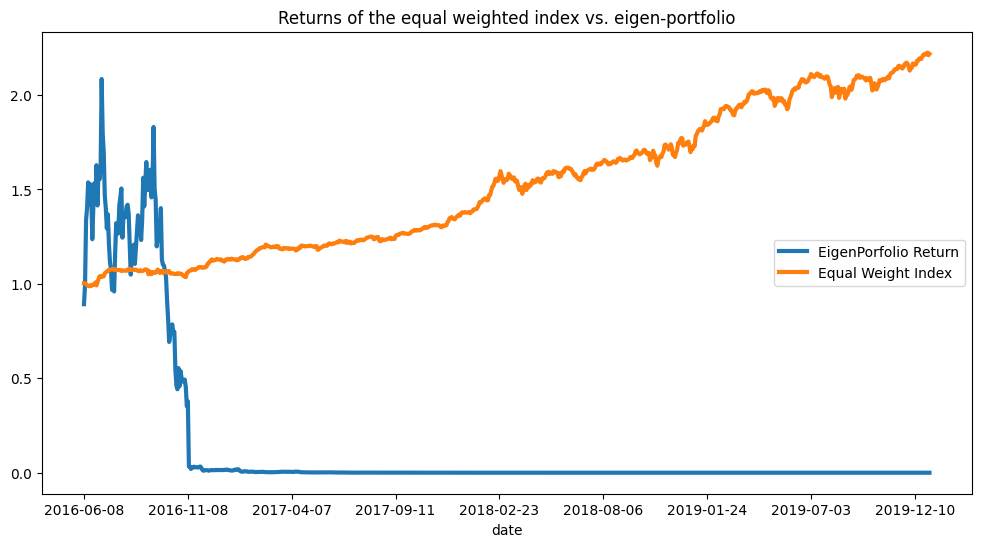

Eigen-Portfolio 9
Return = 128.94%
Volatility = 84.51%
Sharpe = 1.53


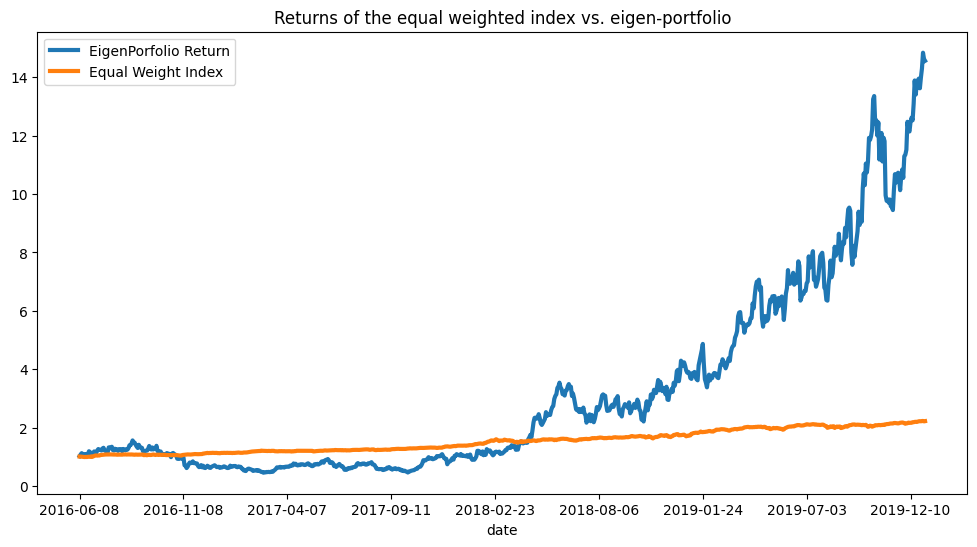

Eigen-Portfolio 10
Return = 76.80%
Volatility = 181.32%
Sharpe = 0.42


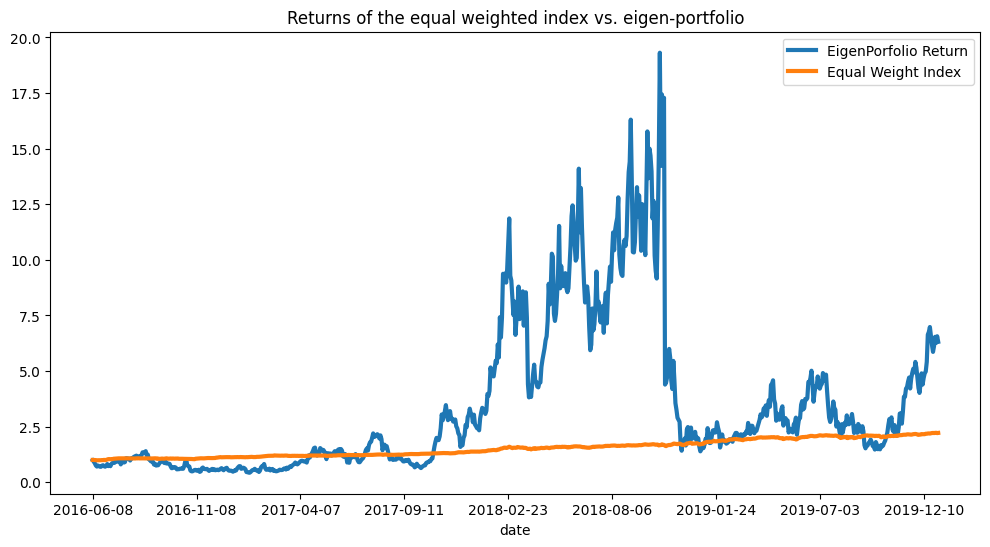

Eigen-Portfolio 11
Return = -97.22%
Volatility = 239.24%
Sharpe = -0.41


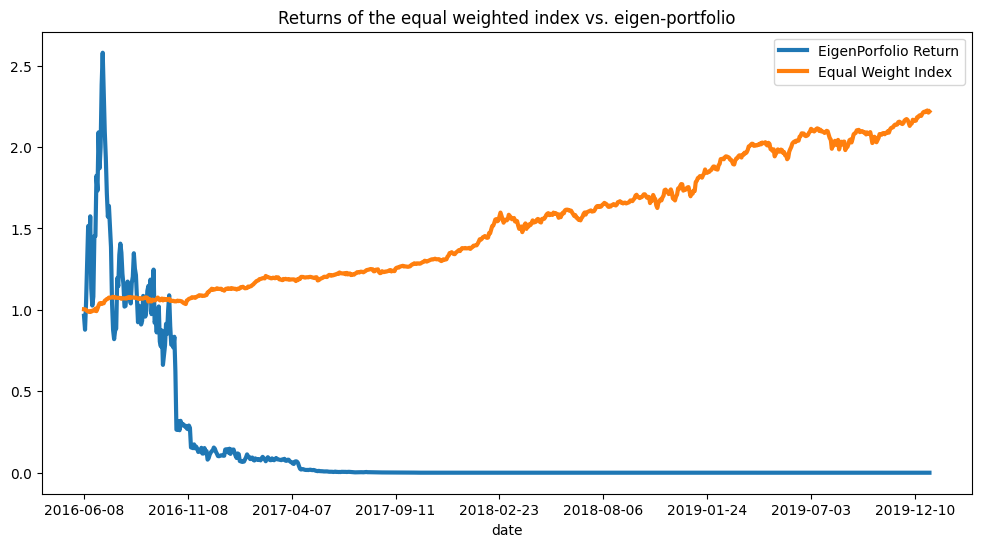

Eigen-Portfolio 12
Return = -70.76%
Volatility = 182.26%
Sharpe = -0.39


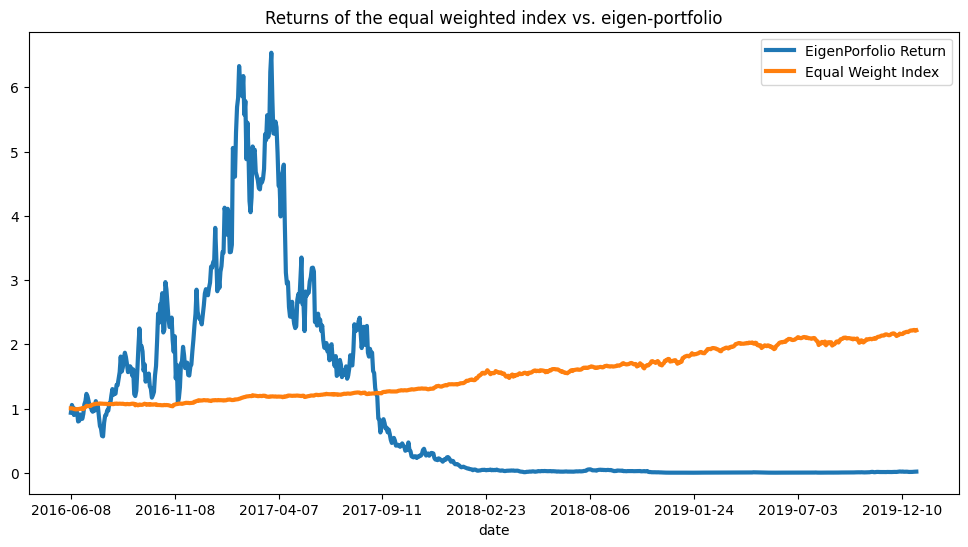

Eigen-Portfolio 13
Return = -61.91%
Volatility = 112.17%
Sharpe = -0.55


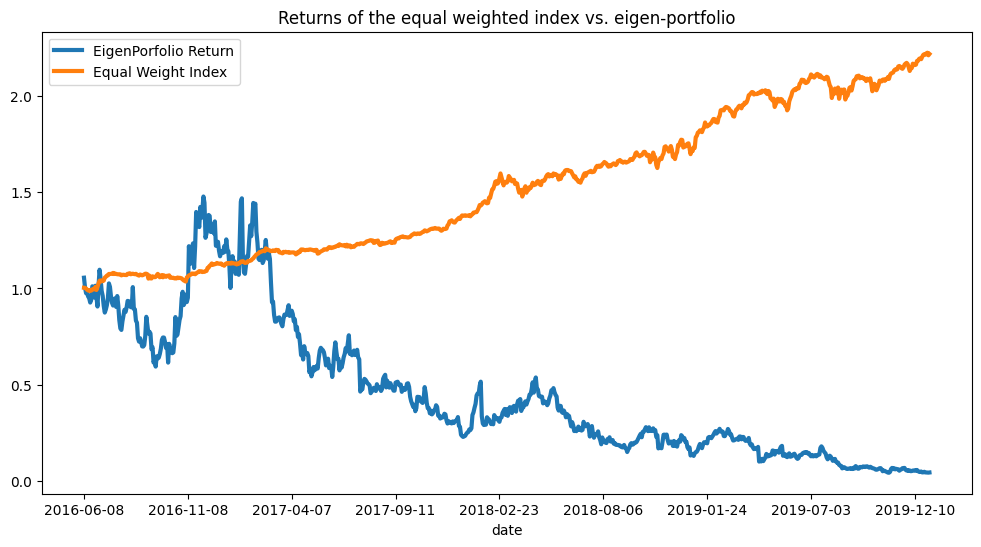

Eigen-Portfolio 14
Return = nan%
Volatility = 603.06%
Sharpe = nan


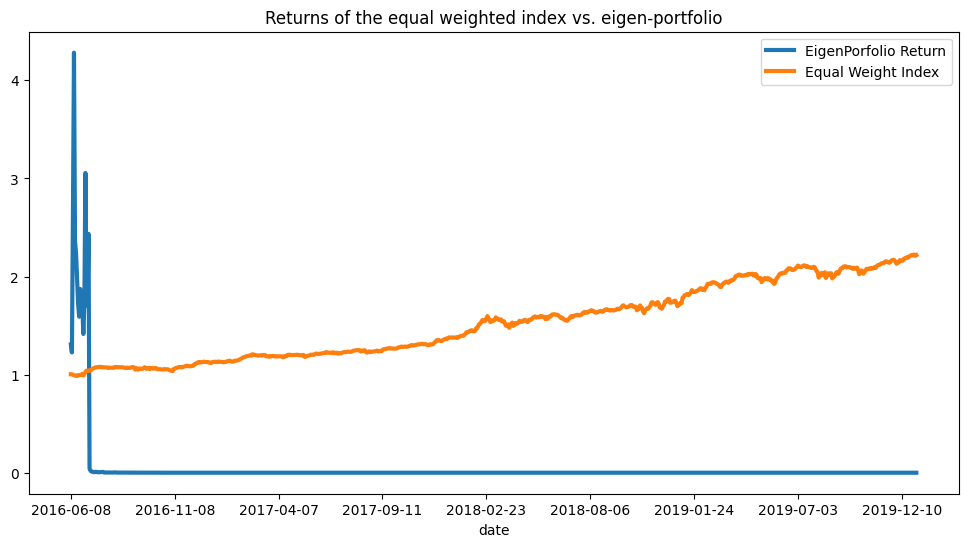

Eigen-Portfolio 15
Return = -88.75%
Volatility = 199.73%
Sharpe = -0.44


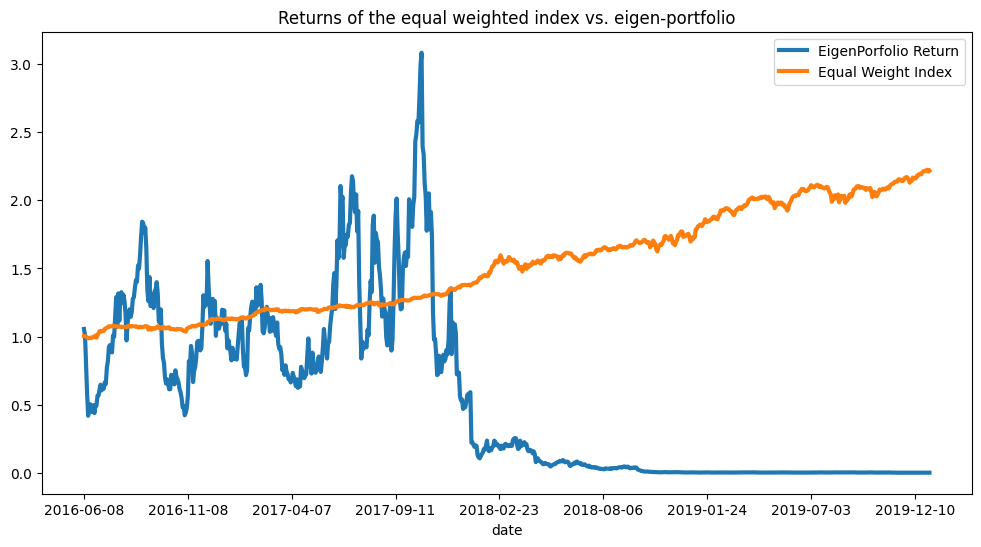

Eigen-Portfolio 16
Return = -99.94%
Volatility = 343.76%
Sharpe = -0.29


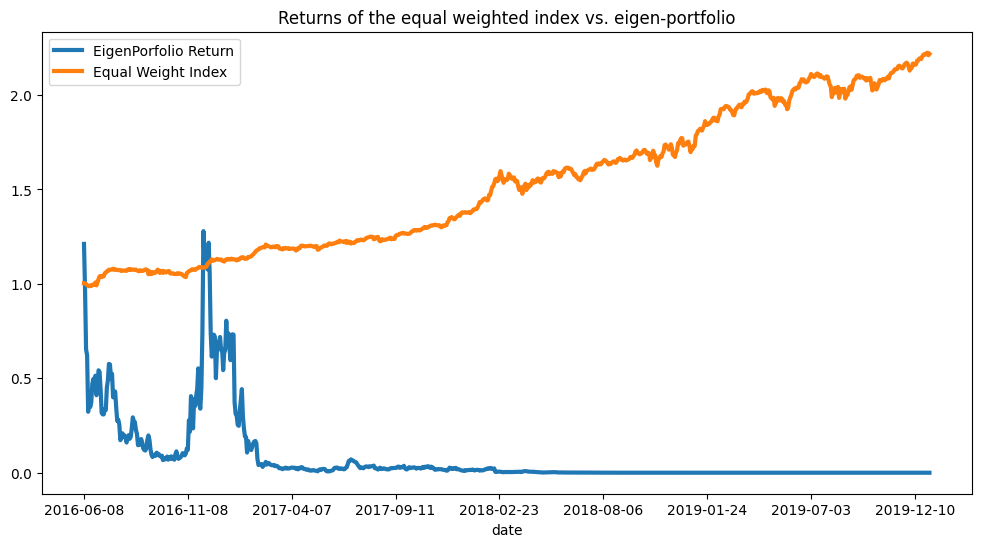

Eigen-Portfolio 17
Return = -100.00%
Volatility = 528.60%
Sharpe = -0.19


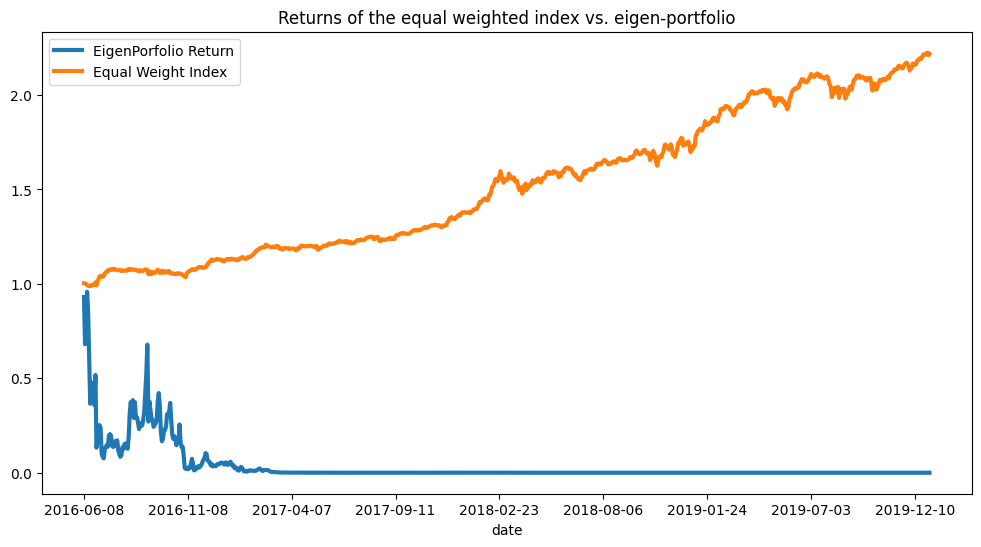

Eigen-Portfolio 18
Return = -88.77%
Volatility = 148.48%
Sharpe = -0.60


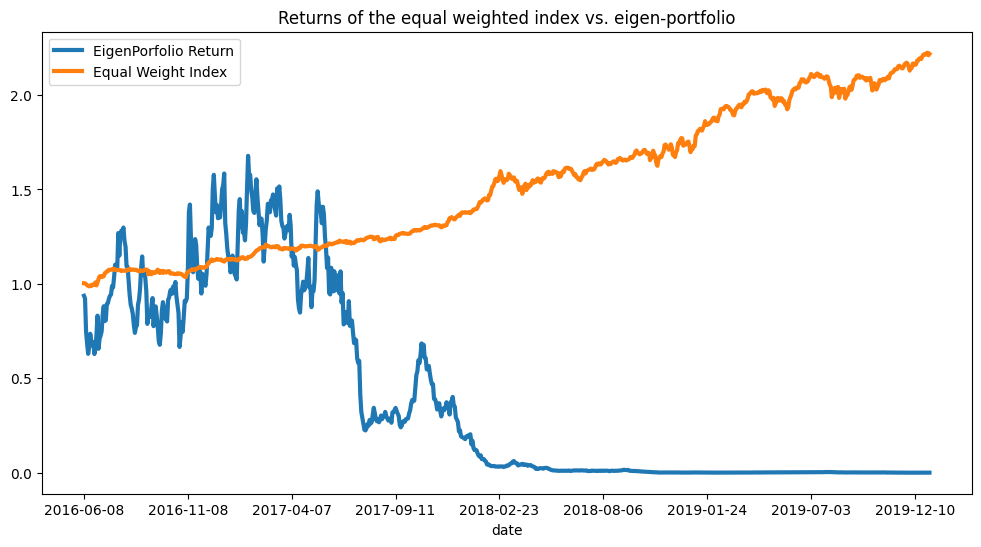

Eigen-Portfolio 19
Return = -98.50%
Volatility = 257.46%
Sharpe = -0.38


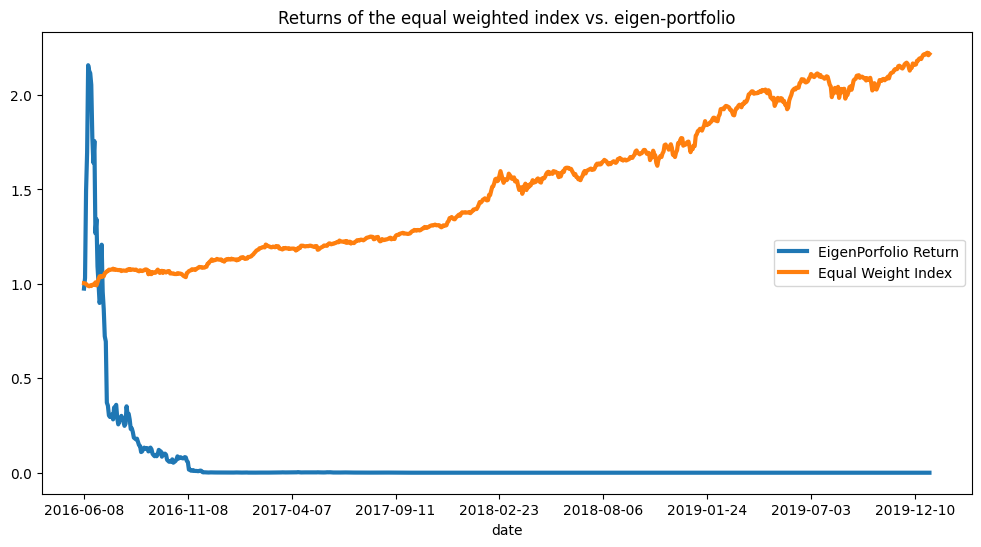

Eigen-Portfolio 20
Return = -90.51%
Volatility = 172.10%
Sharpe = -0.53


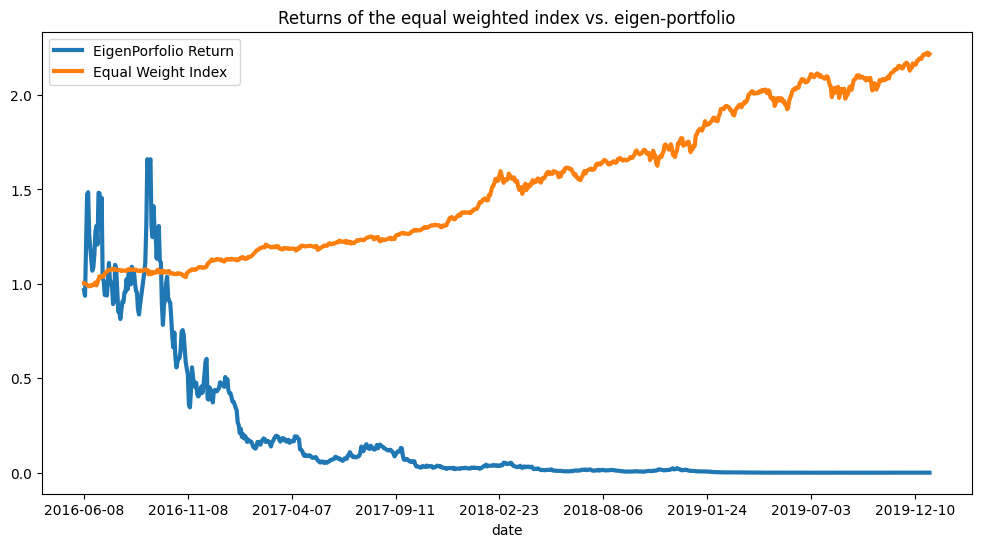

Eigen-Portfolio 21
Return = -100.00%
Volatility = 681.05%
Sharpe = -0.15


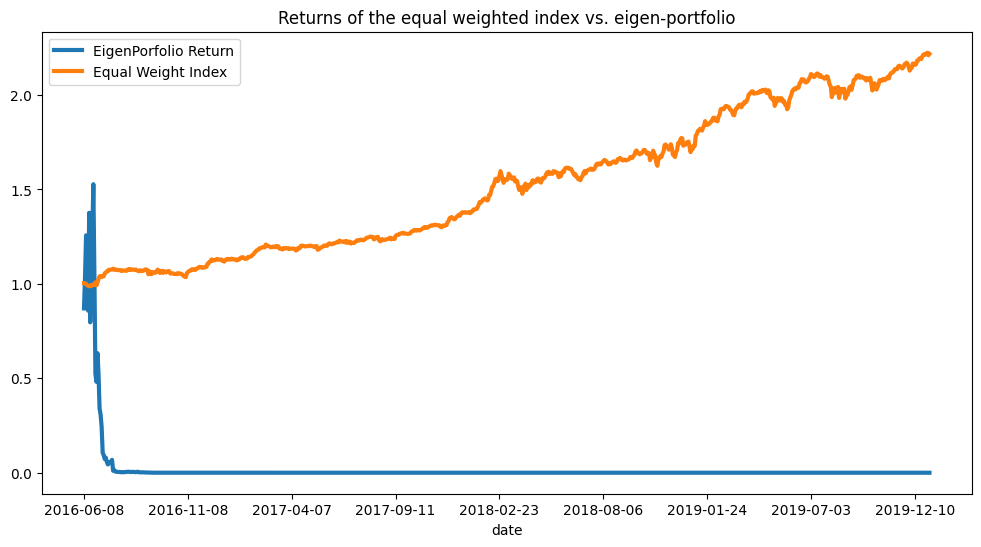

Eigen-Portfolio 22
Return = -80.47%
Volatility = 156.03%
Sharpe = -0.52


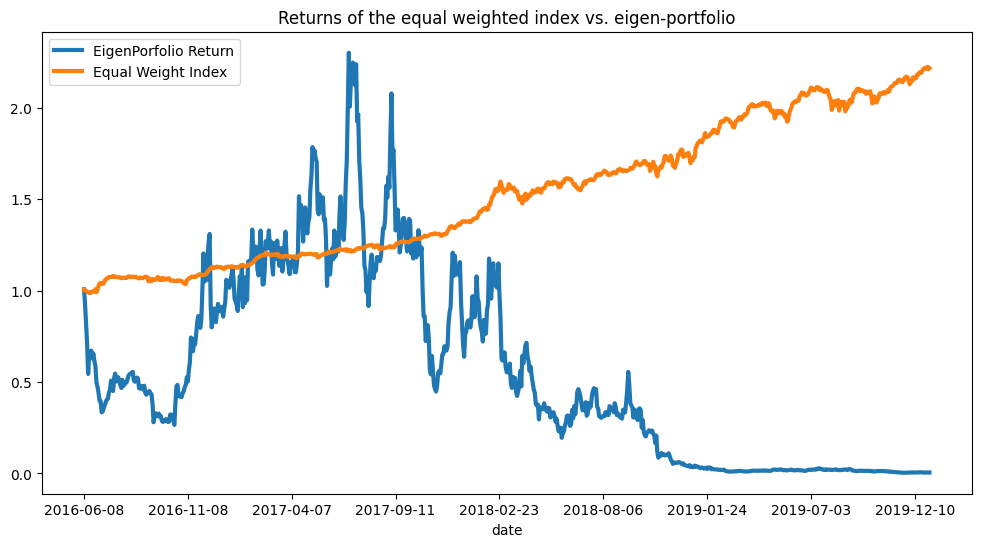

Eigen-Portfolio 23
Return = -100.00%
Volatility = 1385.52%
Sharpe = -0.07


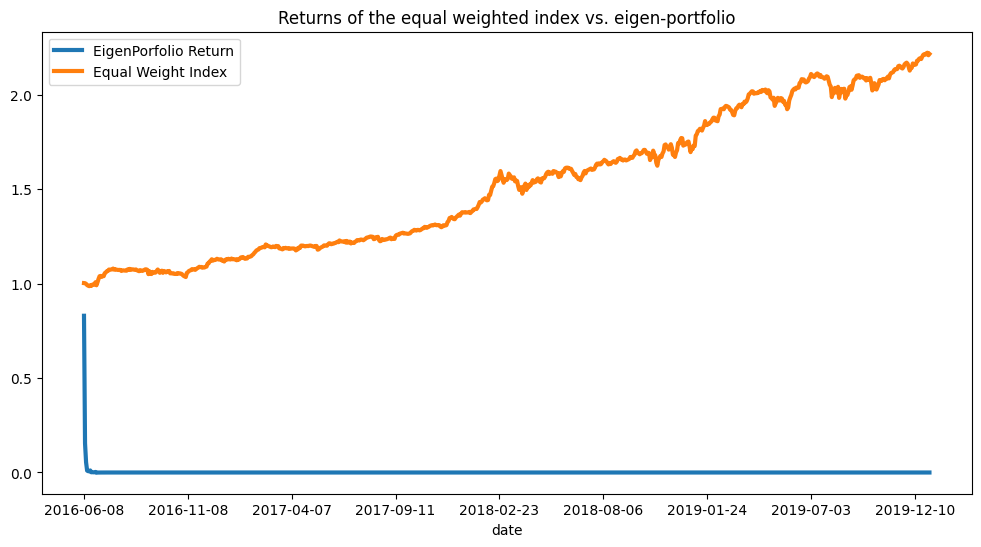

Eigen-Portfolio 24
Return = -11.52%
Volatility = 131.33%
Sharpe = -0.09


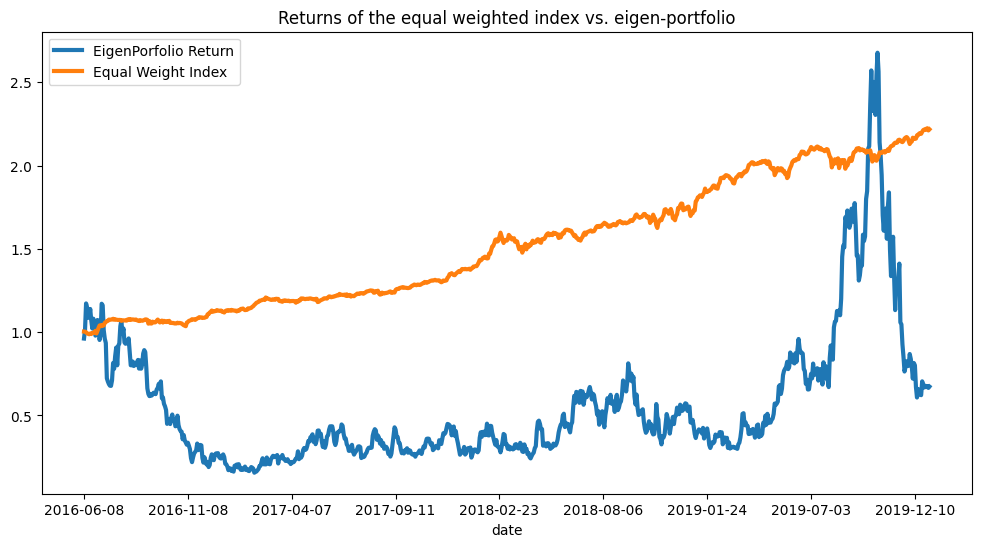

Eigen-Portfolio 25
Return = -93.01%
Volatility = 200.14%
Sharpe = -0.46


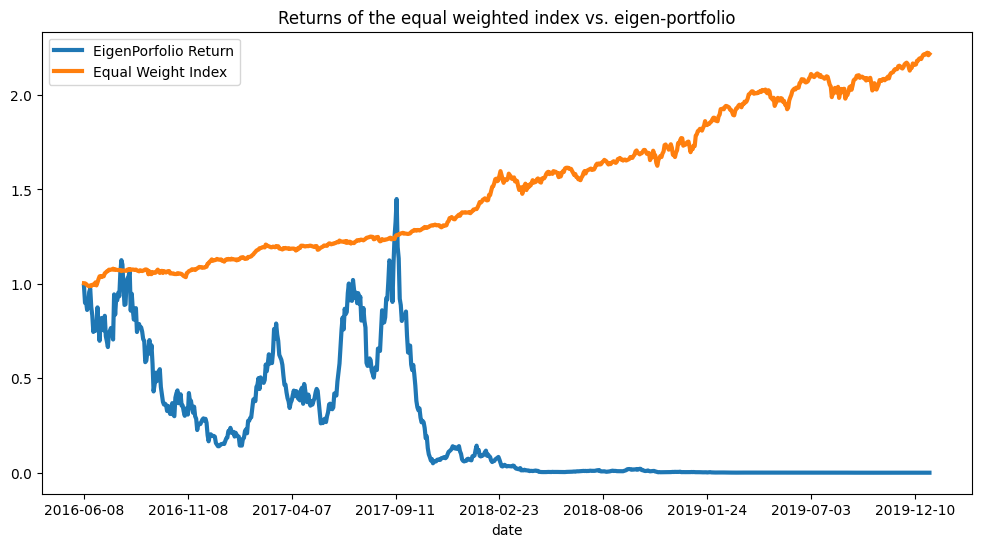

Eigen-Portfolio 26
Return = -99.98%
Volatility = 317.60%
Sharpe = -0.31


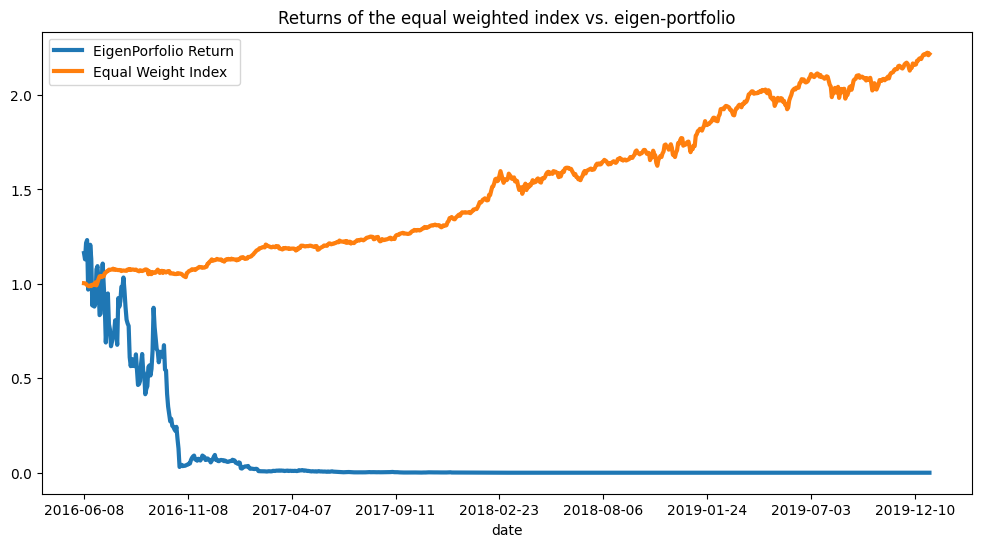

In [74]:
def Backtest(eigen):

     # Plots Principle components returns against real return   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Return = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_testing.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()

for j in range(len(pca.components_)):
    print('Eigen-Portfolio',j)
    Backtest(eigen=weights[j])


#Backtest(eigen=weights[0])

## 5. Conclusion

Looking at the backtesting result, the portfolio with the best result in the training set leads to the best result in the test set. By using PCA, we get independent eigen portfolios with higher return and sharp ratio as compared to market.

However, while it's valuable, backtesting has significant limitations:

**Past Performance is Not Indicative of Future Results:** Market conditions change, and a strategy that worked well in the past may not work well in the future.

**Overfitting:** This occurs when a strategy is excessively tuned to fit the specific nuances of the historical data used for testing. It might look great on past data but fail miserably in live trading because it hasn't captured a robust market edge.

**Data Quality Issues** Inaccurate, incomplete, or improperly adjusted historical data can lead to misleading backtest results.

**Look-Ahead Bias:** Accidentally incorporating information into the simulation that would not have been available at the time the trade decision was made.

**Ignoring Real-World Factors:** Difficulty in perfectly simulating factors like slippage, commission costs, market impact of large orders, and changing liquidity conditions.
